# Coursera Final Capstone Project: Battle of the Neighborhoods

### Project Description / Requirements:

This capstone project will be graded by your peers. This capstone project is worth 70% of your total grade. The project will be completed over the course of 2 weeks. Week 1 submissions will be worth 30% whereas week 2 submissions will be worth 40% of your total grade.

**For this week, you will required to submit the following:**

    A description of the problem and a discussion of the background. (15 marks)
    A description of the data and how it will be used to solve the problem. (15 marks)

**For the second week, the final deliverables of the project will be:**

    A link to your Notebook on your Github repository, showing your code. (15 marks)
    A full report consisting of all of the following components (15 marks):

    Introduction where you discuss the business problem and who would be interested in this project.
    Data where you describe the data that will be used to solve the problem and the source of the data.
    Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.
    Results section where you discuss the results.
    Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.
    Conclusion section where you conclude the report.

    Your choice of a presentation or blogpost. (10 marks)

### Background

**500,000 people moved from California to Arizona from 2010 to 2018, for a variety of reasons, but arguably due to California's high cost of living.**

Hypothetical scenario: data scientist, John Doe, currently lives in California, but he finds a remote data science jobs that would allow him to relocate, and California is too expensive.  He hears good things about the neighboring state, Arizona, **specifically the Phoenix, AZ metropolitan area.**

But John Doe really likes the feel of his current neighbhorhood / current town, in terms of venues nearby: parks, stores, restaurants, etc.  **What community in teh greater Pheonix area would be John's best fit to his current CA city?**

### Goal

Create a notebook that does the following:
1. Allow an input city for comparision (where John Doe currently lives)
2. Load a csv file that compiles suburbs in the Phoenix, AZ metropolitan area (created manually from wiki page: https://en.wikipedia.org/wiki/Phoenix_metropolitan_area)
3. Use FourSquare data to gather venue statistics about both the current input city and ALL community cities in the greater Phoenix area.
4. Use clustering models to determine which city near Phoenix is most similar to John's current city, as a "best-fit" location to move to.

### Data

Most of the data will come from Foursquare API, which includes venue information given a latitude and longitude location: for example, restaurants, museums, parks, entertainment venues, etc., within a fixed distance from a given location.

The only other data used will be a csv file created manually, which just lists out all the communities (with population > 10,000) in the Phoenix, AZ metropolitan area.  List originated from: https://en.wikipedia.org/wiki/Phoenix_metropolitan_area

This csv was constructed manually and saved to github at: https://raw.githubusercontent.com/KyleStewartPhD/IBMcapstone/master/phoenix%20suburbs.csv 

In [3]:
import pandas as pd

cities_url = 'https://raw.githubusercontent.com/KyleStewartPhD/IBMcapstone/master/phoenix%20suburbs.csv'
cities = pd.read_csv(cities_url, thousands=',')  #read csv, while turning numbers strings with commas into regular int format
cities['State'] = 'AZ' #add state information, which is all AZ so far
cities

,City,Population,State
0,Phoenix,1626078,AZ
1,Mesa,496401,AZ
2,Chandler,253458,AZ
3,Scottsdale,249950,AZ
4,Glendale,246709,AZ
5,Gilbert,242354,AZ
6,Tempe,185038,AZ
7,Peoria,168181,AZ
8,Surprise,134085,AZ
9,Avondale,84025,AZ


In [4]:
#These are manual inputs for the starting comparision city.  The city "John Doe" currently lives in, in the description
my_city = "Rancho Cucamonga"
my_state = "CA"
my_pop = 177751

#add this city to our dataframe as the first row
cities.loc[-1] = [my_city, my_pop, my_state]  # add a row with input city
cities.index = cities.index + 1  # shifting index
cities = cities.sort_index()  # sorting by index

cities

,City,Population,State
0,Rancho Cucamonga,177751,CA
1,Phoenix,1626078,AZ
2,Mesa,496401,AZ
3,Chandler,253458,AZ
4,Scottsdale,249950,AZ
5,Glendale,246709,AZ
6,Gilbert,242354,AZ
7,Tempe,185038,AZ
8,Peoria,168181,AZ
9,Surprise,134085,AZ


#### Import all the libraries we're going to use

In [5]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you need to install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you need to install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [6]:
#Note: geolocator is finnicky sometimes.  Might have to run this cell a couple times before it works correctly for all cities.
lats = []
longs = []
for i in range(0,cities.shape[0]):
    if cities['City'].iloc[i]=='Maricopa':
        address = "Maricopa, Pinal County, AZ, United States"  #otherwise, for this one city, the API returns long/lat for COUNTY, not city
    else:
        address = cities['City'].iloc[i]+', '+ cities['State'].iloc[i]+', United States' #get city, state, country address string
    geolocator = Nominatim(user_agent="phoenix_az_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of '+ address + ' is {}, {}.'.format(latitude, longitude))
    lats.append(latitude)
    longs.append(longitude)

The geograpical coordinate of Rancho Cucamonga, CA, United States is 34.1033192, -117.5751735.
The geograpical coordinate of Phoenix, AZ, United States is 33.4484367, -112.0741417.
The geograpical coordinate of Mesa, AZ, United States is 33.4151117, -111.8314773.
The geograpical coordinate of Chandler, AZ, United States is 33.3062223, -111.8413317.
The geograpical coordinate of Scottsdale, AZ, United States is 33.4942189, -111.9260184.
The geograpical coordinate of Glendale, AZ, United States is 33.5386858, -112.1859941.
The geograpical coordinate of Gilbert, AZ, United States is 33.3527632, -111.7890373.
The geograpical coordinate of Tempe, AZ, United States is 33.4255056, -111.9400125.
The geograpical coordinate of Peoria, AZ, United States is 33.5806115, -112.2372942.
The geograpical coordinate of Surprise, AZ, United States is 33.6292271, -112.3680189.
The geograpical coordinate of Avondale, AZ, United States is 33.4354989, -112.3495572.
The geograpical coordinate of Goodyear, AZ, 

In [7]:
#add new lat and long info to dataframe
cities['Latitude'] = lats
cities['Longitude'] = longs
cities

,City,Population,State,Latitude,Longitude
0,Rancho Cucamonga,177751,CA,34.103319,-117.575174
1,Phoenix,1626078,AZ,33.448437,-112.074142
2,Mesa,496401,AZ,33.415112,-111.831477
3,Chandler,253458,AZ,33.306222,-111.841332
4,Scottsdale,249950,AZ,33.494219,-111.926018
5,Glendale,246709,AZ,33.538686,-112.185994
6,Gilbert,242354,AZ,33.352763,-111.789037
7,Tempe,185038,AZ,33.425506,-111.940012
8,Peoria,168181,AZ,33.580612,-112.237294
9,Surprise,134085,AZ,33.629227,-112.368019


In [8]:
phoenix_lat = cities['Latitude'].iloc[1]
phoenix_long = cities['Longitude'].iloc[1]

# create map of New York using latitude and longitude values
phoenix_map = folium.Map(location=[phoenix_lat, phoenix_long], zoom_start=9)

# add markers to map
for lat, lng, city in zip(cities['Latitude'], cities['Longitude'], cities['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(phoenix_map)  
    
phoenix_map

### OK, so we have the lat/long data of all pertinent cities, and we have a nice map of the cities around Phoenix.  

### Now let's gather Foursquare venue data for all cities.  These will be the inputs to our clustering model

In [9]:
#Foursquare credentials
CLIENT_ID = 'SJYY0EQQ5BWSVO21FST51XCBSUHIM3DQQJDQTUT01CUVESAZ' # your Foursquare ID
CLIENT_SECRET = 'KGGU0NVWSLI5CEGLLMED4RW4VSHVDEZLNRGST0AUH1IBJLVY' # your Foursquare Secret
VERSION = '20200701' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SJYY0EQQ5BWSVO21FST51XCBSUHIM3DQQJDQTUT01CUVESAZ
CLIENT_SECRET:KGGU0NVWSLI5CEGLLMED4RW4VSHVDEZLNRGST0AUH1IBJLVY


Let's start by looking at venues around our input town:

In [10]:
city_name = my_city #this is the "target city" from earlier

city_data = cities[cities['City']==city_name]

city_latitude = cities['Latitude'].values[0] # neighborhood latitude value
city_longitude = cities['Longitude'].values[0] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(city_name, 
                                                               city_latitude, 
                                                               city_longitude))

# get Foursquare venues 
radius = 2000 #2000 m from city center
LIMIT = 100 #limit to 200 results
latitude = city_latitude
longitude = city_longitude
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

results = requests.get(url).json()
results    



Latitude and longitude values of Rancho Cucamonga are 34.1033192, -117.5751735.


{'meta': {'code': 200, 'requestId': '5f061004ad353c77ab71305e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Rancho Cucamonga',
  'headerFullLocation': 'Rancho Cucamonga',
  'headerLocationGranularity': 'city',
  'totalResults': 99,
  'suggestedBounds': {'ne': {'lat': 34.12131921800002,
    'lng': -117.55347566725078},
   'sw': {'lat': 34.085319181999985, 'lng': -117.59687133274923}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5484f880498e1787e92e515d',
       'name': 'K-Towne88',
       'location': {'address': '10455 Foothill Blvd #101',
        'crossStreet': 'at Haven Ave',
        'lat': 34.106048880916006,
        'lng': -117.57

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,K-Towne88,Korean Restaurant,34.106049,-117.576762
1,Panera Bread,Bakery,34.107140,-117.575372
2,Haven City Market,Food Court,34.100049,-117.574065
3,Sushi Martini,Japanese Restaurant,34.105499,-117.570918
4,Starbucks,Coffee Shop,34.106130,-117.568530
5,The Poke Place,Asian Restaurant,34.108002,-117.571613
6,Yogurtland,Frozen Yogurt Shop,34.106873,-117.568968
7,The Coffee Bean & Tea Leaf,Coffee Shop,34.105686,-117.576451
8,Baked Dessert Bar,Cupcake Shop,34.105870,-117.578390
9,Chipotle Mexican Grill,Mexican Restaurant,34.106183,-117.568860


Define a function to search for venue types for ALL neighbhorhoods, just like we did above.

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
# run the function for all neighbhorhoods
city_venues = getNearbyVenues(names=cities['City'],
                                   latitudes=cities['Latitude'],
                                   longitudes=cities['Longitude']
                                  )

Rancho Cucamonga
Phoenix
Mesa
Chandler
Scottsdale
Glendale
Gilbert
Tempe
Peoria
Surprise
Avondale
Goodyear
Buckeye
Casa Grande
Maricopa
Apache Junction
Queen Creek
El Mirage
Florence
Fountain Hills
Eloy
Paradise Valley
Coolidge


In [15]:
print("venues shape is:", city_venues.shape)

print("each city had how many venues?: \n", city_venues.groupby('City').count()['Venue'] )

print('There are {} uniques categories.'.format(len(city_venues['Venue Category'].unique())))
#city_venues.head()

venues shape is: (872, 7)
each city had how many venues?: 
 City
Apache Junction      38
Avondale             22
Buckeye              17
Casa Grande          13
Chandler             50
Coolidge             12
El Mirage            12
Eloy                  9
Florence             16
Fountain Hills       23
Gilbert              46
Glendale             39
Goodyear              7
Maricopa             21
Mesa                 55
Paradise Valley       4
Peoria               22
Phoenix             100
Queen Creek          68
Rancho Cucamonga     82
Scottsdale          100
Surprise             16
Tempe               100
Name: Venue, dtype: int64
There are 209 uniques categories.


**OK now let's clean up the data a bit so we can run clustering. Start by one-hot encoding venue categories¶**


In [185]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
city_onehot['City'] = city_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head()


,City,ATM,Accessories Store,Advertising Agency,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Australian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cable Car,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Chinese Restaurant,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Stadium,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,English Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Opera House,Optical Shop,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Post Office,Pub,Public Art,Real Estate Office,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Rancho Cucamonga,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rancho Cucamonga,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Rancho Cucamonga,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [186]:
print("venues shape is : ", city_onehot.shape)

city_grouped = city_onehot.groupby('City').mean().reset_index()
print("grouped venues shape is : ", city_grouped.shape)

#add population as data to keep (for city similarity)
city_grouped = city_grouped.sort_values(by='City')
cities_sorted = cities.sort_values(by='City').reset_index(drop=True)
#city_grouped['Population'] = cities_sorted['Population']
city_grouped.head()


venues shape is :  (872, 210)
grouped venues shape is :  (23, 210)


,City,ATM,Accessories Store,Advertising Agency,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Australian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cable Car,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Chinese Restaurant,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Stadium,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,English Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Opera House,Optical Shop,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Post Office,Pub,Public Art,Real Estate Office,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Apache Junction,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.026316,0.026316,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.052632,0.000000,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.000000,0.052632,0.0,0.000000,0.026316,0.00,0.026316,0.026316,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.026316,0.105263,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.026316,0.000000,0.0,0.0,0.0,0.0,0.000000,0.026316,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.026316,0.000000,0.00,0.0,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.026316,0.0,0.00,0.0,0.026316,0.078947,0.052632,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.026316,0.026316,0.0,0.0,0.000000,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.000000,0.026316,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.026316,0.00,0.0

**Lets put them in decending order of most common venues, and create a pandas df*

In [187]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [188]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = city_grouped['City']
#city_venues_sorted['Population'] = city_grouped['City']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Apache Junction,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Gas Station,Convenience Store,Pizza Place,American Restaurant,Breakfast Spot,Liquor Store,Park,Bar,Mexican Restaurant,Sandwich Place,Soup Place,Sports Bar
1,Avondale,Mexican Restaurant,Bakery,Health & Beauty Service,Auto Garage,Convenience Store,Cupcake Shop,Diner,Discount Store,Seafood Restaurant,Burger Joint,Fast Food Restaurant,Fish & Chips Shop,Social Club,Automotive Shop,Locksmith
2,Buckeye,Mexican Restaurant,Discount Store,Gas Station,Pool,Café,Pizza Place,Coffee Shop,Convenience Store,Grocery Store,Bank,Park,Business Service,BBQ Joint,Sandwich Place,Fabric Shop
3,Casa Grande,Construction & Landscaping,Pizza Place,City Hall,Football Stadium,Burger Joint,Burrito Place,New American Restaurant,Café,Chinese Restaurant,Mexican Restaurant,American Restaurant,Ice Cream Shop,Dessert Shop,Eastern European Restaurant,Financial or Legal Service
4,Chandler,Mexican Restaurant,Taco Place,Bar,Beer Bar,Brewery,Café,Italian Restaurant,Sports Bar,Pool,Speakeasy,Hotel,Pub,Indian Restaurant,Intersection,Insurance Office
5,Coolidge,Pizza Place,Mexican Restaurant,Convenience Store,Discount Store,Greek Restaurant,Business Service,Café,Post Office,Cupcake Shop,Cosmetics Shop,Fish & Chips Shop,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Falafel Restaurant
6,El Mirage,Mexican Restaurant,Convenience Store,Grocery Store,Locksmith,Baseball Field,Bakery,Food & Drink Shop,Market,Pizza Place,Cupcake Shop,Fabric Shop,Flower Shop,Fish & Chips Shop,Concert Hall,Financial or Legal Service
7,Eloy,Convenience Store,Grocery Store,Discount Store,Mexican Restaurant,Park,Burger Joint,Post Office,Real Estate Office,Falafel Restaurant,Farmers Market,Fabric Shop,English Restaurant,Fast Food Restaurant,Eastern European Restaurant,Donut Shop
8,Florence,Mexican Restaurant,Sandwich Place,Chinese Restaurant,Bar,Gas Station,General Travel,Greek Restaurant,Arts & Crafts Store,Fast Food Restaurant,Convenience Store,Hardware Store,Food & Drink Shop,Taco Place,Farmers Market,Dog Run
9,Fountain Hills,Grocery Store,Pharmacy,Pizza Place,Bank,Hardware Store,Thrift / Vintage Store,Salon / Barbershop,Japanese Restaurant,Sports Bar,Spanish Restaurant,Shipping Store,Donut Shop,Sandwich Place,Mexican Restaurant,Gym / Fitness Center


#### all right, this dataset is looking good. Let's actually cluster the neighborhoods!

#### We want to try the k-means clustering with different k values to find the "elbow" where the optimal k-value is

In [196]:
from sklearn import preprocessing
city_grouped_clustering = city_grouped

#create min-max scaled variables for population and number of total venues 
scaled_pop = cities_sorted['Population']
scaled_pop = (scaled_pop - scaled_pop.min()) / (scaled_pop.max() - scaled_pop.min())

#create list with total number of venues as a possible feature --> then scale by min-max scaling
n_cities = city_venues.groupby('City')['City'].count().shape[0]
city_venues.groupby('City')['City'].count()
n_venues = []
for i in range(0, n_cities):
    n_venues.append(city_venues.groupby('City')['City'].count()[i])
n_venues = np.array(n_venues)
scaled_n_venues = (n_venues - n_venues.min())/(n_venues.max() - n_venues.min())

#include scaled number of venues as feature (comment out to remove if this messes up model)
#city_grouped_clustering['Number of Venues'] = scaled_n_venues

#include scaeld population as feature (comment out to remove if this messes up model)
city_grouped_clustering['Population'] = scaled_pop

#drop city name for clustering
city_grouped_clustering = city_grouped_clustering.drop('City', 1)

city_grouped_clustering.head()

,ATM,Accessories Store,Advertising Agency,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Australian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cable Car,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Chinese Restaurant,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Stadium,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,English Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Opera House,Optical Shop,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Post Office,Pub,Public Art,Real Estate Office,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Population
0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.026316,0.026316,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.052632,0.000000,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.000000,0.052632,0.0,0.000000,0.026316,0.00,0.026316,0.026316,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.026316,0.105263,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.026316,0.000000,0.0,0.0,0.0,0.0,0.000000,0.026316,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.026316,0.000000,0.00,0.0,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.026316,0.0,0.00,0.0,0.026316,0.078947,0.052632,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.026316,0.026316,0.0,0.0,0.000000,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.000000,0.026316,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.026316,0.00,0.0,0.0,0.00,

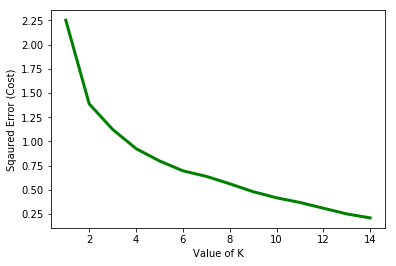

In [197]:
#let's try different k-means clustering fits, with different k's, to find optimum k value
import matplotlib.pyplot as plt  
from matplotlib import style 
%matplotlib inline

cost =[] 
kmax=15
for i in range(1, kmax): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(city_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, kmax), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k 
kclusters = 10  #there isn't exactly an elbow, but k=7 looks good enough

In [198]:
# run k-means clustering with best cluster k
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

#city_grouped_clustering.head()

array([5, 4, 5, 2, 0, 7, 4, 6, 5, 5, 0, 0, 9, 5, 0, 3, 5, 1, 5, 5, 0, 8,
       5], dtype=int32)

In [199]:
# add clustering labels
try: 
    city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_) 
except: 
    #if you've run the above line before alreayd you can't instert it again.  Just re-define it
    city_venues_sorted['Cluster Labels'] = kmeans.labels_

city_merged = cities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_merged = city_merged.join(city_venues_sorted.set_index('City'), on='City')

target_cluster = city_merged['Cluster Labels'][city_merged['City']==target_city].values[0]
print(str(np.sum(city_merged['Cluster Labels']==target_cluster)-1)+" cities in AZ are in same cluster as CA target.")

city_merged


8 cities in AZ are in same cluster as CA target.


,City,Population,State,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Rancho Cucamonga,177751,CA,34.103319,-117.575174,5,Mexican Restaurant,Clothing Store,Japanese Restaurant,Burger Joint,Coffee Shop,Bakery,Pizza Place,Seafood Restaurant,Fast Food Restaurant,Financial or Legal Service,Bank,Pharmacy,Discount Store,Mobile Phone Shop,Asian Restaurant
1,Phoenix,1626078,AZ,33.448437,-112.074142,1,Coffee Shop,Hotel,American Restaurant,Lounge,Pizza Place,Music Venue,Salon / Barbershop,Basketball Stadium,Bar,Cocktail Bar,Breakfast Spot,Rock Club,Pub,Park,New American Restaurant
2,Mesa,496401,AZ,33.415112,-111.831477,0,Mexican Restaurant,Sandwich Place,Bank,Brewery,Hotel,Bookstore,Fast Food Restaurant,Bakery,Arts & Crafts Store,Pizza Place,Performing Arts Venue,Paper / Office Supplies Store,Music Store,Museum,Antique Shop
3,Chandler,253458,AZ,33.306222,-111.841332,0,Mexican Restaurant,Taco Place,Bar,Beer Bar,Brewery,Café,Italian Restaurant,Sports Bar,Pool,Speakeasy,Hotel,Pub,Indian Restaurant,Intersection,Insurance Office
4,Scottsdale,249950,AZ,33.494219,-111.926018,0,Coffee Shop,Bar,Mexican Restaurant,American Restaurant,New American Restaurant,Hotel,Taco Place,Italian Restaurant,Pizza Place,Café,Ice Cream Shop,Sushi Restaurant,Sporting Goods Shop,Plaza,Burger Joint
5,Glendale,246709,AZ,33.538686,-112.185994,0,Mexican Restaurant,Bar,American Restaurant,Coffee Shop,Fried Chicken Joint,Bank,Tea Room,Pizza Place,Ice Cream Shop,Sandwich Place,Sports Bar,Steakhouse,Boutique,Restaurant,Italian Restaurant
6,Gilbert,242354,AZ,33.352763,-111.789037,0,Mexican Restaurant,Plaza,Ice Cream Shop,Sandwich Place,Italian Restaurant,Coffee Shop,New American Restaurant,Bridal Shop,Café,Restaurant,Candy Store,Pool,Pizza Place,Convenience Store,Museum
7,Tempe,185038,AZ,33.425506,-111.940012,5,Coffee Shop,Pizza Place,Sandwich Place,Breakfast Spot,American Restaurant,Mexican Restaurant,Bar,Dessert Shop,Restaurant,Seafood Restaurant,Brewery,Chinese Restaurant,Beer Garden,Burger Joint,Mediterranean Restaurant
8,Peoria,168181,AZ,33.580612,-112.237294,5,Fast Food Restaurant,Theater,Coffee Shop,Park,Clothing Store,Chinese Restaurant,Donut Shop,Mexican Restaurant,Breakfast Spot,Big Box Store,Latin American Restaurant,Bar,Automotive Shop,Pharmacy,Home Service
9,Surprise,134085,AZ,33.629227,-112.368019,8,Baseball Field,Baseball Stadium,Dog Run,Fast Food Restaurant,Sushi Restaurant,Lake,Hotel,Park,Mexican Restaurant,Coffee Shop,Locksmith,Pool,Accessories Store,Tennis Court,Eastern European Restaurant





So how did the clustering divide up the neighbhorhoods? Let's look at each cluster to see common themes

In [200]:
target_city = cities['City'].iloc[0]
#print(target_city)
target_cluster = city_merged['Cluster Labels'][city_merged['City']==target_city].values[0]
#print(target_cluster)
print("Keep in mind, the cluster number for target town: " + target_city + " is Cluster #" + str(target_cluster))

Keep in mind, the cluster number for target town: Rancho Cucamonga is Cluster #5


In [201]:
for i in range(0, kclusters):
    print("\nfor Cluster ", i)
    print("1st: ", city_merged[city_merged['Cluster Labels'] == i]['1st Most Common Venue'].values )    
    print("2nd: ", city_merged[city_merged['Cluster Labels'] == i]['2nd Most Common Venue'].values )


for Cluster  0
1st:  ['Mexican Restaurant' 'Mexican Restaurant' 'Coffee Shop'
 'Mexican Restaurant' 'Mexican Restaurant']
2nd:  ['Sandwich Place' 'Taco Place' 'Bar' 'Bar' 'Plaza']

for Cluster  1
1st:  ['Coffee Shop']
2nd:  ['Hotel']

for Cluster  2
1st:  ['Construction & Landscaping']
2nd:  ['Pizza Place']

for Cluster  3
1st:  ['Football Stadium']
2nd:  ['Pawn Shop']

for Cluster  4
1st:  ['Mexican Restaurant' 'Mexican Restaurant']
2nd:  ['Bakery' 'Convenience Store']

for Cluster  5
1st:  ['Mexican Restaurant' 'Coffee Shop' 'Fast Food Restaurant'
 'Mexican Restaurant' 'American Restaurant' 'Fast Food Restaurant'
 'Mexican Restaurant' 'Mexican Restaurant' 'Grocery Store']
2nd:  ['Clothing Store' 'Pizza Place' 'Theater' 'Discount Store'
 'Fast Food Restaurant' 'Pharmacy' 'Pizza Place' 'Sandwich Place'
 'Pharmacy']

for Cluster  6
1st:  ['Convenience Store']
2nd:  ['Grocery Store']

for Cluster  7
1st:  ['Pizza Place']
2nd:  ['Mexican Restaurant']

for Cluster  8
1st:  ['Baseball Fiel

Let's map out the clusters and see where they fall in the city

In [202]:
phoenix_lat = cities['Latitude'].iloc[1]
phoenix_long = cities['Longitude'].iloc[1]

# create map
map_clusters = folium.Map(location=[phoenix_lat, phoenix_long], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['City'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

So there are a number of communities similar to our target.  Which one is closest in population size?

In [203]:
city_merged[city_merged['Cluster Labels']==target_cluster].sort_values(by='Population')

,City,Population,State,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
19,Fountain Hills,24583,AZ,33.611711,-111.717361,5,Grocery Store,Pharmacy,Pizza Place,Bank,Hardware Store,Thrift / Vintage Store,Salon / Barbershop,Japanese Restaurant,Sports Bar,Spanish Restaurant,Shipping Store,Donut Shop,Sandwich Place,Mexican Restaurant,Gym / Fitness Center
18,Florence,26074,AZ,33.031451,-111.387343,5,Mexican Restaurant,Sandwich Place,Chinese Restaurant,Bar,Gas Station,General Travel,Greek Restaurant,Arts & Crafts Store,Fast Food Restaurant,Convenience Store,Hardware Store,Food & Drink Shop,Taco Place,Farmers Market,Dog Run
16,Queen Creek,39184,AZ,33.248386,-111.634158,5,Mexican Restaurant,Pizza Place,Sandwich Place,American Restaurant,Fast Food Restaurant,Bakery,Park,Coffee Shop,Pharmacy,Chinese Restaurant,Ice Cream Shop,Fried Chicken Joint,Burger Joint,Big Box Store,Convenience Store
15,Apache Junction,40538,AZ,33.415048,-111.549578,5,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Gas Station,Convenience Store,Pizza Place,American Restaurant,Breakfast Spot,Liquor Store,Park,Bar,Mexican Restaurant,Sandwich Place,Soup Place,Sports Bar
14,Maricopa,48007,AZ,33.058129,-112.047755,5,American Restaurant,Fast Food Restaurant,Discount Store,Coffee Shop,BBQ Joint,Clothing Store,Convenience Store,Donut Shop,Flower Shop,Lawyer,Gas Station,Pizza Place,Train Station,Wings Joint,Ice Cream Shop
12,Buckeye,68453,AZ,33.370275,-112.583867,5,Mexican Restaurant,Discount Store,Gas Station,Pool,Café,Pizza Place,Coffee Shop,Convenience Store,Grocery Store,Bank,Park,Business Service,BBQ Joint,Sandwich Place,Fabric Shop
8,Peoria,168181,AZ,33.580612,-112.237294,5,Fast Food Restaurant,Theater,Coffee Shop,Park,Clothing Store,Chinese Restaurant,Donut Shop,Mexican Restaurant,Breakfast Spot,Big Box Store,Latin American Restaurant,Bar,Automotive Shop,Pharmacy,Home Service
0,Rancho Cucamonga,177751,CA,34.103319,-117.575174,5,Mexican Restaurant,Clothing Store,Japanese Restaurant,Burger Joint,Coffee Shop,Bakery,Pizza Place,Seafood Restaurant,Fast Food Restaurant,Financial or Legal Service,Bank,Pharmacy,Discount Store,Mobile Phone Shop,Asian Restaurant
7,Tempe,185038,AZ,33.425506,-111.940012,5,Coffee Shop,Pizza Place,Sandwich Place,Breakfast Spot,American Restaurant,Mexican Restaurant,Bar,Dessert Shop,Restaurant,Seafood Restaurant,Brewery,Chinese Restaurant,Beer Garden,Burger Joint,Mediterranean Restaurant


Looks like **Peoria, AZ or Tempe, AZ** are best matches to target city by population

Assuming we have some additional info from client:

**choose the city that also has similar total number of venues, if possible.**

In [31]:
city_venues.groupby('City').count()['Venue']

City
Apache Junction      38
Avondale             22
Buckeye              17
Casa Grande          13
Chandler             50
Coolidge             12
El Mirage            12
Eloy                  9
Florence             16
Fountain Hills       23
Gilbert              46
Glendale             39
Goodyear              7
Maricopa             21
Mesa                 55
Paradise Valley       4
Peoria               22
Phoenix             100
Queen Creek          68
Rancho Cucamonga     82
Scottsdale          100
Surprise             16
Tempe               100
Name: Venue, dtype: int64

## **Winner for best-match city is.... Tempe, AZ**